In [1]:
import copy
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model, calculate_rdm, plot_rdm
import multitask.models.task_switching.utils as utils
import multitask.models.task_switching.hooks as hooks

from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figure14_rdm_task_switching_noise.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')
path_pickle = os.path.join('pickle', 'rdm_task_switching.pickle')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


Running on CPU.


  0%|          | 0/3 [00:00<?, ?it/s]

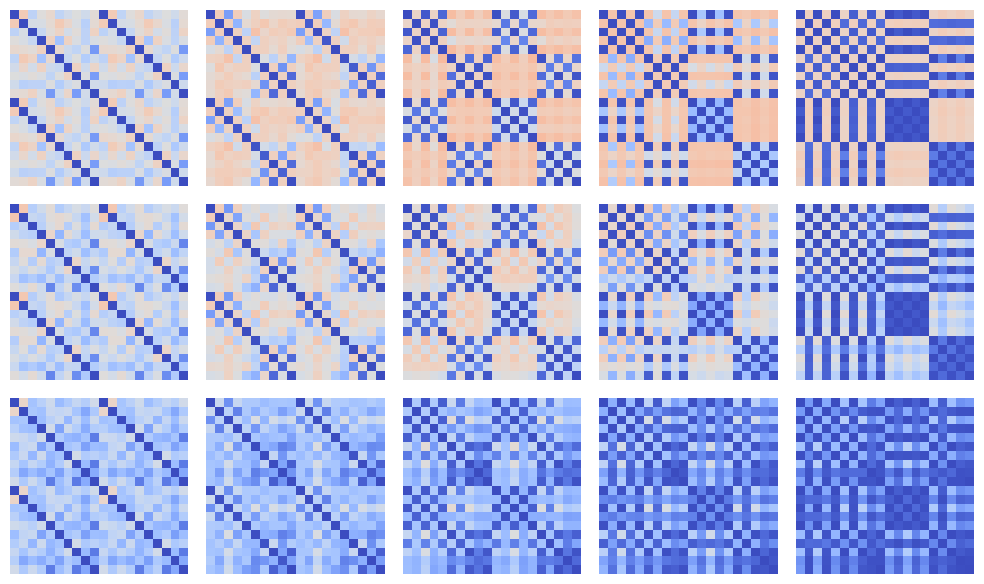

In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm = []
data_size = task_switching_tasks['parity']['data'].data.shape

seed = seeds[0]
torch.manual_seed(seed)

array_noise = [0, 0.5, 1.0]
num_noise = len(array_noise)
images = []

fig, ax = plt.subplots(num_noise, num_layers, figsize=(2 * num_layers, 2 * num_noise))


for i_noise, noise in tqdm(enumerate(array_noise), total=num_noise):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])

    noise_data = noise * torch.randn(size=data_size)
    noise_task_switching_tasks = copy.deepcopy(task_switching_tasks)
    noise_task_switching_tasks['parity']['data'].data += noise_data
    noise_task_switching_tasks['value']['data'].data += noise_data

    images.append((noise, noise_task_switching_tasks['parity']['data'].data[0].numpy().reshape(28, 28)))

    _, test_dataloaders = dataset.create_dict_dataloaders(noise_task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    rdm_dict = calculate_rdm(activations,
                             noise_task_switching_tasks,
                             num_hidden,
                             numbers)
    list_rdm.append(rdm_dict)

    plot_rdm(ax[i_noise], rdm_dict, num_hidden, idxs_contexts, cmap='coolwarm', vmin=0, vmax=1)

fig.tight_layout()
plt.show()

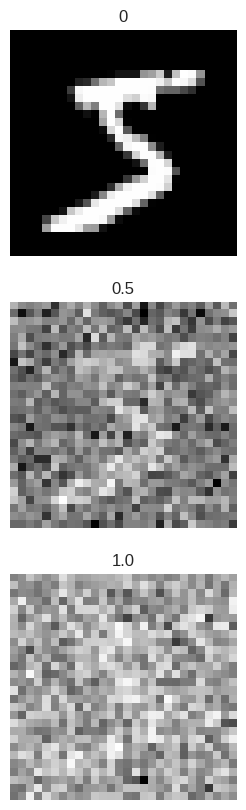

In [10]:
fig, ax = plt.subplots(num_noise, 1, figsize=(10, 10))

for i, (noise, image) in enumerate(images):
    ax[i].imshow(image, cmap='Greys_r')
    ax[i].set_title(noise)
    ax[i].axis('off')

plt.show()

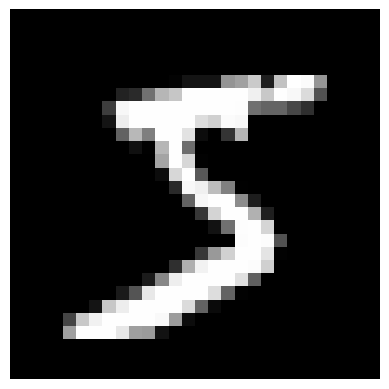

In [11]:
plt.imshow(task_switching_tasks['parity']['data'].data[0].reshape(28, 28), cmap='Greys_r')
plt.axis('off')
plt.show()